
# 🧪 Évaluation RAG (POC Métier) avec **RAGAS** — FULL (axes 0–1 fixes + corr robuste + dashboard multi‑runs)

**Jeu de données attendu (colonnes) :**
- Références métier : `question`, `reference_answer`, `sharepoint_document`
- Sorties RAG : `ragas_question`, `ragas_answer`, `ragas_contexts`, `ragas_ground_truth`

**Métriques RAGAS :** faithfulness, answer_correctness, relevancy (auto), context_precision, context_recall  
**Plus :** doc_precision/recall/F1, diagnostics enrichis, graphiques (axes 0–1 fixes), matrice de corrélation robuste, dashboard **multi‑runs**.


## 0) Installation & vérifications

In [16]:

# À exécuter si besoin :
# !pip install "ragas>=0.3.1,<0.4" "langchain>=0.2" "datasets>=2.20" pandas tiktoken openpyxl

import os, sys, platform, importlib
os.environ.setdefault("TQDM_NOTEBOOK", "0")  # évite dépendance ipywidgets pour tqdm

def check_pkg(name):
    try:
        m = importlib.import_module(name)
        return getattr(m, "__version__", "installed")
    except Exception as e:
        return f"not found: {e}"

print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("ragas:", check_pkg("ragas"))
print("langchain:", check_pkg("langchain"))
print("datasets:", check_pkg("datasets"))
print("pandas:", check_pkg("pandas"))


Python: 3.13.5 | OS: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
ragas: 0.3.2
langchain: 0.3.27
datasets: 4.0.0
pandas: 2.3.2


## 1) Configuration — LLM & chemins de fichiers

In [6]:

import os

# LLM pour RAGAS: "openai" | "claude" | "gemini" | "ollama"
RAGAS_LLM_PROVIDER = os.getenv("RAGAS_LLM_PROVIDER", "openai").lower()

OPENAI_MODEL  = os.getenv("OPENAI_MODEL",  "gpt-4o-mini")
CLAUDE_MODEL  = os.getenv("CLAUDE_MODEL",  "claude-3-5-sonnet-20240620")
GEMINI_MODEL  = os.getenv("GEMINI_MODEL",  "gemini-1.5-pro")
OLLAMA_MODEL  = os.getenv("OLLAMA_MODEL",  "llama3.1:8b")

# Clés d'API attendues dans l'environnement
os.environ["OPENAI_API_KEY"]     = "your-openai-api-key"
# os.environ["ANTHROPIC_API_KEY"]  = "..."
# os.environ["GOOGLE_API_KEY"]     = "..."

# Données
DATA_PATH = os.getenv("DATA_PATH", "reference_qa_manuel_template.csv")

# Sorties
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Provider:", RAGAS_LLM_PROVIDER)
print("Data path:", DATA_PATH)
print("Output dir:", OUTPUT_DIR)


Provider: openai
Data path: reference_qa_manuel_template.csv
Output dir: outputs


## 2) Chargement du CSV & aperçu

In [7]:

import pandas as pd, os

if not os.path.exists(DATA_PATH):
    alt = '../data/reference/reference_qa_manuel_template.csv'
    if os.path.exists(alt):
        DATA_PATH = alt
        print(f"INFO: DATA_PATH introuvable, utilisation de {alt}")
    else:
        raise FileNotFoundError(f"CSV introuvable: {DATA_PATH}")

raw_df = pd.read_csv(DATA_PATH)
print("Shape:", raw_df.shape)
display(raw_df.head(5))
print("Colonnes:", list(raw_df.columns))


INFO: DATA_PATH introuvable, utilisation de ../data/reference/reference_qa_manuel_template.csv
Shape: (12, 8)


,question_id,question,reference_answer,sharepoint_document,ragas_question,ragas_answer,ragas_contexts,ragas_ground_truth
0,QNeo001,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo.,Note de cadrage - Projet Neo.txt,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt ||| Archive t...
1,QNeo002,Quel est l'objectif principal du Projet Néo ?,Le Projet Néo vise à développer un nouvel algo...,Note de cadrage - Projet Neo.txt,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
2,QNeo003,Qui est le lead developer assigné au projet ?,Sophie Martin est le lead developer assigné au...,Note de cadrage - Projet Neo.txt,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
3,QNeo004,Quelles sont les compétences de David Chen ?,"David Chen possède des compétences en Python, ...",Repertoire equipe - Projet Neo.txt,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...",[Document: Repertoire equipe - Projet Neo.txt]...,Repertoire equipe - Projet Neo.txt
4,QNeo005,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin.,Repertoire equipe - Projet Neo.txt,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,[Document: Repertoire equipe - Projet Neo.txt]...,Repertoire equipe - Projet Neo.txt


Colonnes: ['question_id', 'question', 'reference_answer', 'sharepoint_document', 'ragas_question', 'ragas_answer', 'ragas_contexts', 'ragas_ground_truth']



## 3) Normalisation → Clés RAGAS & variables d’analyse

**Mapping POC → RAGAS**  
- *question évaluée* = `ragas_question` si présent, sinon `question`  
- *answer* = `ragas_answer`  
- *contexts* (List[str]) = `ragas_contexts` (auto‑parse séparateurs/JSON)  
- *ground_truth* (texte métier) = `reference_answer`  
- *reference_docs* (List[str]) = `sharepoint_document` (analyses documentaires)  
- *cited_docs* (List[str]) = `ragas_ground_truth` (documents cités par la réponse)


In [10]:

import ast, math

df = raw_df.copy()

def to_list_generic(x):
    if x is None or (isinstance(x, float) and math.isnan(x)): return []
    if isinstance(x, list): return [str(xx).strip() for xx in x if str(xx).strip()]
    if isinstance(x, str):
        s = x.strip()
        # JSON / Python-lists
        if (s.startswith('[') and s.endswith(']')) or (s.startswith('(') and s.endswith(')')):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    return [str(xx).strip() for xx in parsed if str(xx).strip()]
            except Exception: 
                pass
        # Split on common separators
        for sep in ["|||", "§§", ";;", "##", "\n", ","]:
            if sep in s: return [p.strip() for p in s.split(sep) if p.strip()]
        return [s]
    return [str(x).strip()]

# Question évaluée
if "ragas_question" in df.columns and df["ragas_question"].notna().any():
    q_series = df["ragas_question"].fillna(df.get("question",""))
else:
    q_series = df.get("question","")

dataset_dict = {
    "question": q_series.astype(str).tolist(),
    "answer": df.get("ragas_answer","").fillna("").astype(str).tolist(),
    "contexts": [to_list_generic(v) for v in df.get("ragas_contexts","").fillna("").tolist()],
    "ground_truth": df.get("reference_answer","").fillna("").astype(str).tolist(),
}

# Infos documentaires pour analyses
aux_docs = {
    "reference_docs": [to_list_generic(v) for v in df.get("sharepoint_document","").fillna("").tolist()],
    "cited_docs": [to_list_generic(v) for v in df.get("ragas_ground_truth","").fillna("").tolist()],
}

print("Exemple question:", dataset_dict["question"][0] if dataset_dict["question"] else "n/a")
print("Exemple answer:", dataset_dict["answer"][0] if dataset_dict["answer"] else "n/a")
print("Exemple contexts[0] (2 premiers):", dataset_dict["contexts"][0][:2] if dataset_dict["contexts"] else "n/a")
print("Exemple ground_truth:", dataset_dict["ground_truth"][0] if dataset_dict["ground_truth"] else "n/a")
print("Exemple cited docs:", aux_docs["cited_docs"][0] if aux_docs["cited_docs"] else "n/a")

Exemple question: Qui est le chef de projet du Projet Néo ?
Exemple answer: Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.
Exemple contexts[0] (2 premiers): ['[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce.', "[Document: Note de cadrage - Projet Neo.txt] L'équipe clé comprend Marc Dubois comme Chef de Projet, Sophie Martin comme Lead Developer et David Chen comme Expert Data Science."]
Exemple ground_truth: Marc Dubois est le chef de projet du Projet Néo.
Exemple cited docs: ['Note de cadrage - Projet Neo.txt', 'Archive test doc.txt']


## 4) Construction du Dataset

In [11]:

from datasets import Dataset as HFDataset
hf_dataset = HFDataset.from_dict(dataset_dict)
hf_dataset


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 12
})

## 5) LLM compatible RAGAS (Wrapper)

In [12]:

from ragas.llms import LangchainLLMWrapper

def build_llm(provider: str):
    provider = provider.lower().strip()
    if provider == "openai":
        from langchain_openai import ChatOpenAI
        lc = ChatOpenAI(model=OPENAI_MODEL, temperature=0); return LangchainLLMWrapper(lc)
    elif provider == "claude":
        from langchain_anthropic import ChatAnthropic
        lc = ChatAnthropic(model=CLAUDE_MODEL, temperature=0); return LangchainLLMWrapper(lc)
    elif provider == "gemini":
        from langchain_google_genai import ChatGoogleGenerativeAI
        lc = ChatGoogleGenerativeAI(model=GEMINI_MODEL, temperature=0); return LangchainLLMWrapper(lc)
    elif provider == "ollama":
        try:
            from langchain_community.chat_models import ChatOllama
            lc = ChatOllama(model=OLLAMA_MODEL)
        except Exception:
            from langchain_community.llms import Ollama
            lc = Ollama(model=OLLAMA_MODEL)
        return LangchainLLMWrapper(lc)
    else:
        raise ValueError(f"Provider non supporté: {provider}")

llm = build_llm(RAGAS_LLM_PROVIDER)
print("✅ LLM prêt pour RAGAS:", type(llm).__name__, "| provider:", RAGAS_LLM_PROVIDER)


✅ LLM prêt pour RAGAS: LangchainLLMWrapper | provider: openai


## 6) Métriques RAGAS (auto‑détection de *Relevancy*)

In [13]:

from ragas.metrics import faithfulness, answer_correctness, context_precision, context_recall

try:
    from ragas.metrics import response_relevancy as _relevancy_metric
    RELEVANCY_NAME = "response_relevancy"
except Exception:
    from ragas.metrics import answer_relevancy as _relevancy_metric
    RELEVANCY_NAME = "answer_relevancy"

metrics = [faithfulness, answer_correctness, _relevancy_metric, context_precision, context_recall]
print("Métrique de pertinence retenue:", RELEVANCY_NAME)


Métrique de pertinence retenue: answer_relevancy


## 7) Exécution de l’évaluation

In [14]:

from ragas import evaluate, __version__ as ragas_version
import os
print("RAGAS version:", ragas_version)

result = evaluate(
    dataset=hf_dataset,
    metrics=metrics,
    llm=llm,
    raise_exceptions=False,
    show_progress=False,  # pas d'ipywidgets
)

df_results = result.to_pandas()
display(df_results.head(10))

csv_out = os.path.join(OUTPUT_DIR, "ragas_raw_results.csv")
df_results.to_csv(csv_out, index=False, encoding="utf-8")
print("Résultats enregistrés ->", csv_out)


RAGAS version: 0.3.2


,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,Qui est le chef de projet du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.000000,0.743916,0.998186,0.5,1.0
1,Quel est l'objectif principal du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,1.000000,0.993853,0.985759,1.0,1.0
2,Qui est le lead developer assigné au projet ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.000000,0.996659,0.930775,0.5,1.0
3,Quelles sont les compétences de David Chen ?,[[Document: Repertoire equipe - Projet Neo.txt...,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.000000,0.907657,0.881353,0.0,1.0
4,Qui est le manager de Sophie Martin ?,[[Document: Repertoire equipe - Projet Neo.txt...,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.500000,0.745691,0.953929,1.0,1.0
5,Quelle est la date limite pour le premier PoC ...,[[Document: Compte-Rendu de Reunion.txt] Proch...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.666667,0.621984,0.926650,1.0,1.0
6,Quel framework a été confirmé pour le modèle p...,[[Document: Compte-Rendu de Reunion.txt] Décis...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,1.000000,0.741270,0.967857,1.0,1.0
7,Qui dirige l'équipe Data Warehouse ?,[[Document: Repertoire equipe - Projet Neo.txt...,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,1.000000,0.621241,0.765512,1.0,1.0
8,Quelle base de données est envisagée pour le p...,[[Document: Note de cadrage - Projet Neo.txt] ...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,1.000000,0.995710,0.882434,1.0,1.0
9,Quand est prévue la revue de projet avec Carol...,[[Document: Compte-Rendu de Reunion.txt] Proch...,La revue de projet avec Carole Lambert est pro...,Une revue de projet est fixée avec Carole Lamb...,1.000000,0.621936,0.990623,0.5,1.0


Résultats enregistrés -> outputs/ragas_raw_results.csv


## 8) Synthèse des scores (0–1)

In [15]:

import numpy as np, json
from datetime import datetime
import os

rel_col = "response_relevancy" if "response_relevancy" in df_results.columns else ("answer_relevancy" if "answer_relevancy" in df_results.columns else None)

wanted_cols = ["faithfulness", "answer_correctness", "context_precision", "context_recall"]
if rel_col: wanted_cols.insert(2, rel_col)

present = [c for c in wanted_cols if c in df_results.columns]
summary = {c: float(np.nanmean(df_results[c])) for c in present}

print("📊 Scores moyens :")
for k, v in summary.items():
    print(f" - {k}: {v:.3f}")

summary_out = os.path.join(OUTPUT_DIR, "ragas_summary.json")
with open(summary_out, "w", encoding="utf-8") as f:
    json.dump({
        "generated_at": datetime.now().isoformat(),
        "provider": RAGAS_LLM_PROVIDER,
        "model": {"openai": OPENAI_MODEL, "claude": CLAUDE_MODEL, "gemini": GEMINI_MODEL, "ollama": OLLAMA_MODEL}.get(RAGAS_LLM_PROVIDER, "n/a"),
        "scores": summary,
    }, f, ensure_ascii=False, indent=2)
print("Synthèse enregistrée ->", summary_out)


📊 Scores moyens :
 - faithfulness: 0.847
 - answer_correctness: 0.798
 - answer_relevancy: 0.926
 - context_precision: 0.736
 - context_recall: 1.000
Synthèse enregistrée -> outputs/ragas_summary.json


## 9) Diagnostics enrichis & features dérivées

In [10]:

import numpy as np, pandas as pd, re, os

def wc(s: str) -> int:
    if not isinstance(s, str): s = str(s)
    return len(re.findall(r"\w+", s))

def jaccard_words(a: str, b: str) -> float:
    A = set([w.lower() for w in re.findall(r"\w+", a or "")])
    B = set([w.lower() for w in re.findall(r"\w+", b or "")])
    if not A and not B: return 0.0
    return len(A & B) / max(1, len(A | B))

def f1(p, r): return 0.0 if (p+r)==0 else 2*p*r/(p+r)

contexts_concat = ["\n".join(c) if isinstance(c, (list, tuple)) else str(c) for c in dataset_dict["contexts"]]

doc_precisions, doc_recalls, doc_f1s = [], [], []
for i in range(len(aux_docs["reference_docs"])):
    refs = set([x.lower() for x in aux_docs["reference_docs"][i]])
    cits = set([x.lower() for x in aux_docs["cited_docs"][i]])
    inter = refs & cits
    p = len(inter)/max(1, len(cits)) if len(cits)>0 else 0.0
    r = len(inter)/max(1, len(refs)) if len(refs)>0 else 0.0
    doc_precisions.append(p); doc_recalls.append(r); doc_f1s.append(f1(p,r))

enriched = pd.DataFrame({
    "question": dataset_dict["question"],
    "answer": dataset_dict["answer"],
    "ground_truth": dataset_dict["ground_truth"],
    "contexts_concat": contexts_concat,
    "n_contexts": [len(c) if isinstance(c, (list, tuple)) else 0 for c in dataset_dict["contexts"]],
    "avg_context_len": [np.mean([wc(x) for x in c]) if isinstance(c, (list, tuple)) and len(c)>0 else 0 for c in dataset_dict["contexts"]],
    "total_context_len": [np.sum([wc(x) for x in c]) if isinstance(c, (list, tuple)) else 0 for c in dataset_dict["contexts"]],
    "answer_len": [wc(a) for a in dataset_dict["answer"]],
    "question_len": [wc(q) for q in dataset_dict["question"]],
    "gt_len": [wc(g) for g in dataset_dict["ground_truth"]],
    "context_coverage_jaccard": [jaccard_words(dataset_dict["ground_truth"][i], contexts_concat[i]) for i in range(len(contexts_concat))],
    "answer_coverage_jaccard": [jaccard_words(dataset_dict["ground_truth"][i], dataset_dict["answer"][i]) for i in range(len(contexts_concat))],
    "doc_precision": doc_precisions,
    "doc_recall": doc_recalls,
    "doc_f1": doc_f1s,
})

df_all = pd.concat([enriched, df_results.reset_index(drop=True)], axis=1)

enriched_out = os.path.join(OUTPUT_DIR, "ragas_results_enriched.csv")
df_all.to_csv(enriched_out, index=False, encoding="utf-8")
print("Enrichi ->", enriched_out)
display(df_all.head(5))


Enrichi -> outputs/ragas_results_enriched.csv


,question,answer,ground_truth,contexts_concat,n_contexts,avg_context_len,total_context_len,answer_len,question_len,gt_len,...,doc_f1,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,[Document: Note de cadrage - Projet Neo.txt] L...,2,26.000000,52,15,9,10,...,1.0,Qui est le chef de projet du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.0,0.743916,0.998186,0.5,1.0
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,[Document: Note de cadrage - Projet Neo.txt] L...,3,21.666667,65,43,8,32,...,1.0,Quel est l'objectif principal du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,1.0,0.993853,0.985760,1.0,1.0
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,[Document: Note de cadrage - Projet Neo.txt] L...,2,15.500000,31,11,8,10,...,1.0,Qui est le lead developer assigné au projet ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.0,0.996659,0.930798,0.5,1.0
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",[Document: Repertoire equipe - Projet Neo.txt]...,4,6.000000,24,16,7,12,...,1.0,Quelles sont les compétences de David Chen ?,[[Document: Repertoire equipe - Projet Neo.txt...,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.0,0.907658,0.881354,0.0,1.0
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,[Document: Repertoire equipe - Projet Neo.txt]...,4,5.500000,22,14,7,8,...,1.0,Qui est le manager de Sophie Martin ?,[[Document: Repertoire equipe - Projet Neo.txt...,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.5,0.745691,0.953929,1.0,1.0


## 10) Histograms (axes **0–1** fixes pour toutes les métriques bornées)

Saved: outputs/hist_faithfulness.png


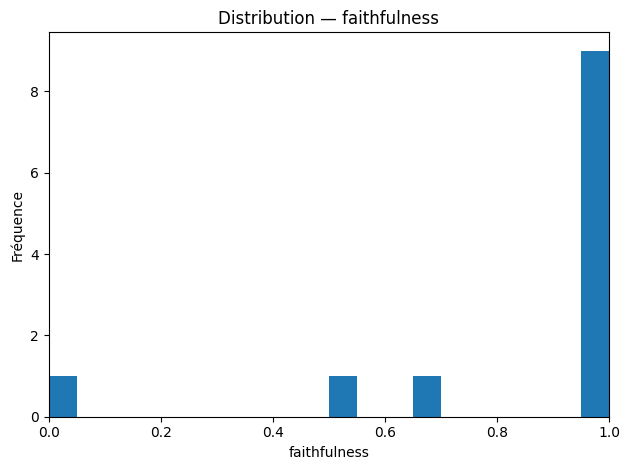

Saved: outputs/hist_answer_correctness.png


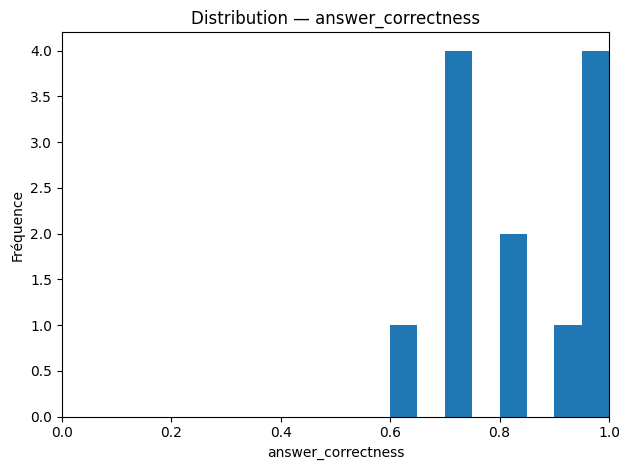

Saved: outputs/hist_context_precision.png


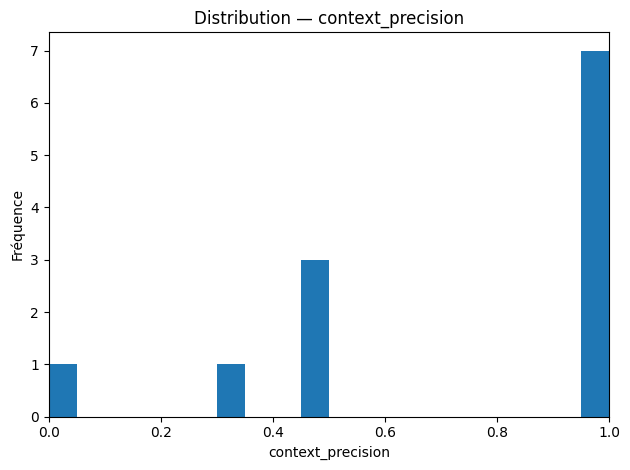

Saved: outputs/hist_context_recall.png


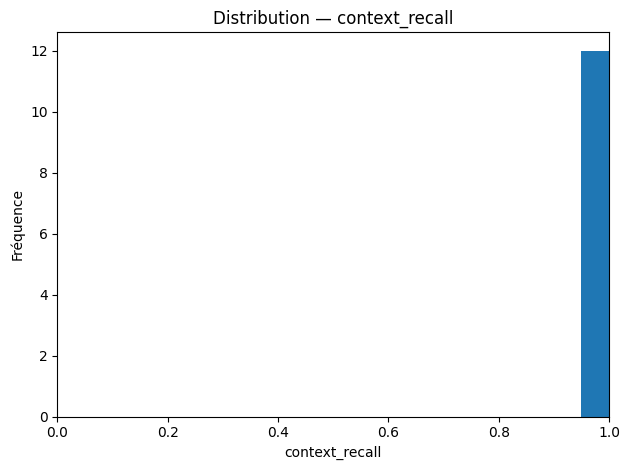

Saved: outputs/hist_answer_relevancy.png


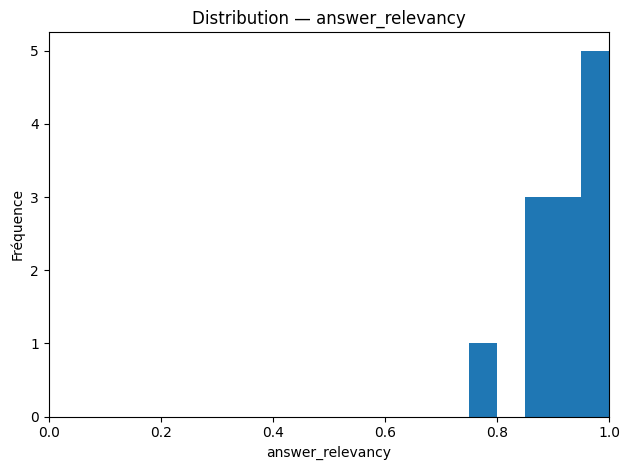

Saved: outputs/hist_doc_precision.png


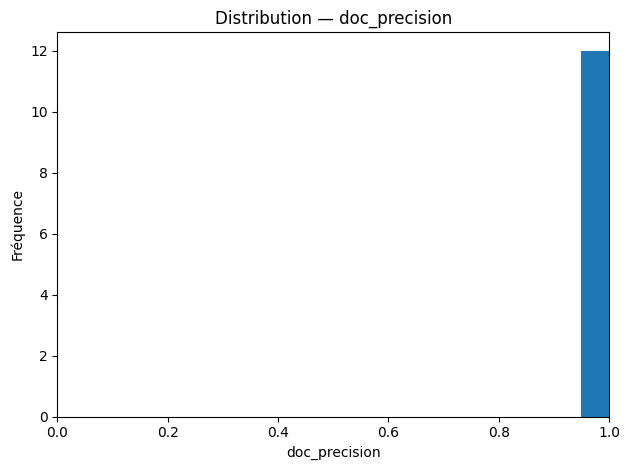

Saved: outputs/hist_doc_recall.png


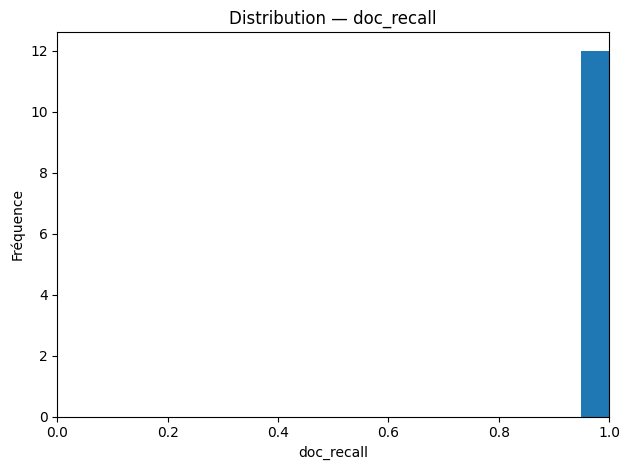

Saved: outputs/hist_doc_f1.png


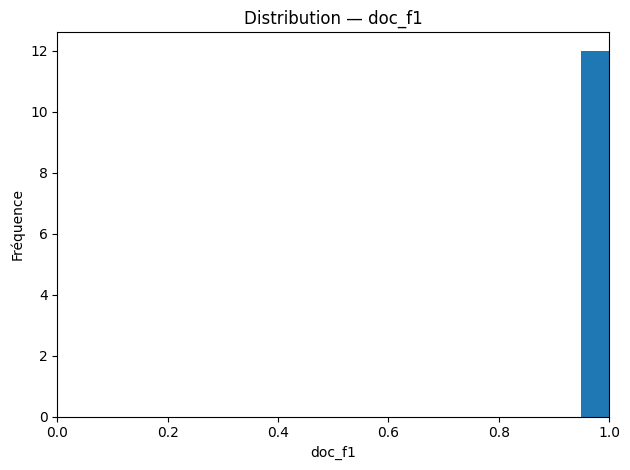

Saved: outputs/hist_context_coverage_jaccard.png


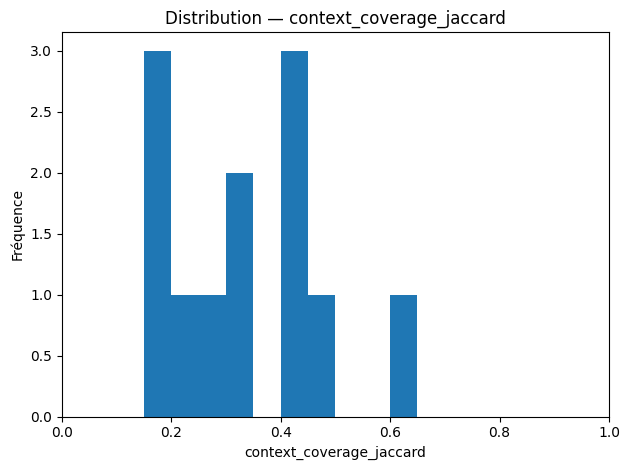

Saved: outputs/hist_answer_coverage_jaccard.png


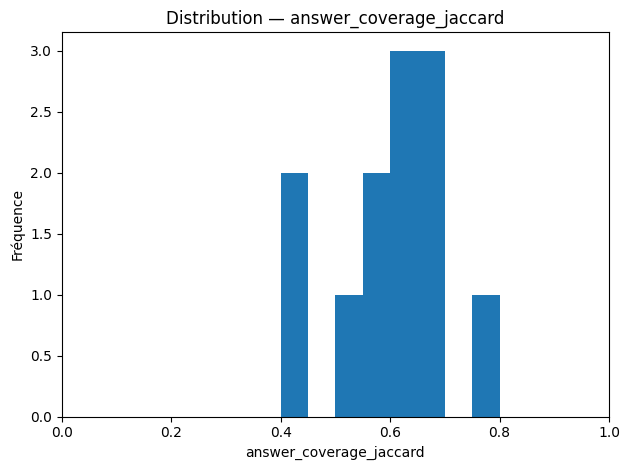

In [11]:

import matplotlib.pyplot as plt, numpy as np, os

BOUNDED01_COLS = [
    "faithfulness","answer_correctness","context_precision","context_recall",
    "response_relevancy","answer_relevancy","doc_precision","doc_recall","doc_f1",
    "context_coverage_jaccard","answer_coverage_jaccard"
]

for col in BOUNDED01_COLS:
    if col in df_all.columns:
        plt.figure()
        bins = np.linspace(0, 1, 21)  # mêmes bornes pour tous
        df_all[col].dropna().clip(0,1).plot(kind="hist", bins=bins, title=f"Distribution — {col}")
        plt.xlabel(col); plt.ylabel("Fréquence"); plt.xlim(0,1)
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, f"hist_{col}.png")
        plt.savefig(outp); print("Saved:", outp)
        plt.show()


## 11) Focus erreurs — Top‑K items les plus faibles

In [12]:

import pandas as pd

def topk_worst(col, k=15):
    if col not in df_all.columns: return pd.DataFrame()
    sub = df_all[["question","answer","ground_truth", col]].copy()
    sub = sub.sort_values(col, ascending=True).head(k)
    return sub

print("### Pires 'answer_correctness'"); display(topk_worst("answer_correctness"))
print("\n### Pires 'faithfulness'"); display(topk_worst("faithfulness"))

rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)
if rel_col:
    print(f"\n### Pires '{rel_col}'"); display(topk_worst(rel_col))

print("\n### Pires 'doc_recall' (documents manquants)"); display(topk_worst("doc_recall"))


### Pires 'answer_correctness'


,question,answer,ground_truth,answer_correctness
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,0.621241
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,0.741270
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,0.743916
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.745691
11,De quel projet stratégique fait partie le Proj...,Le Projet Néo s'inscrit dans le cadre de l'ini...,Le Projet Néo est une composante clé de l'init...,0.747059
10,Quel risque a souligné David Chen concernant l...,David Chen a identifié un risque majeur concer...,David Chen a souligné un risque concernant la ...,0.834138
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.846984
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",0.907658
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.993853
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,0.995704



### Pires 'faithfulness'


,question,answer,ground_truth,faithfulness
10,Quel risque a souligné David Chen concernant l...,David Chen a identifié un risque majeur concer...,David Chen a souligné un risque concernant la ...,0.000000
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.500000
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.666667
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.000000
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.000000
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.000000
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,1.000000
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,1.000000
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,1.000000
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,1.000000



### Pires 'answer_relevancy'


,question,answer,ground_truth,answer_relevancy
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,0.782653
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",0.881354
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,0.882434
11,De quel projet stratégique fait partie le Proj...,Le Projet Néo s'inscrit dans le cadre de l'ini...,Le Projet Néo est une composante clé de l'init...,0.892690
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.927206
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,0.930798
10,Quel risque a souligné David Chen concernant l...,David Chen a identifié un risque majeur concer...,David Chen a souligné un risque concernant la ...,0.942503
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.953929
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,0.967857
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.985760



### Pires 'doc_recall' (documents manquants)


,question,answer,ground_truth,doc_recall
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.0
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,1.0
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.0
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.0
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,1.0
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,1.0
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,1.0
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,1.0
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,1.0
9,Quand est prévue la revue de projet avec Carol...,La revue de projet avec Carole Lambert est pro...,Une revue de projet est fixée avec Carole Lamb...,1.0


## 12) Scatters — relations entre métriques (axes 0–1 si métriques bornées)

Saved: outputs/scatter_faithfulness_vs_answer_correctness.png


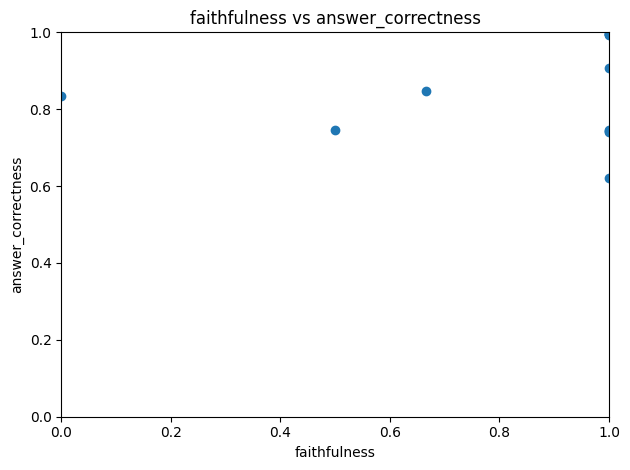

Saved: outputs/scatter_answer_relevancy_vs_answer_correctness.png


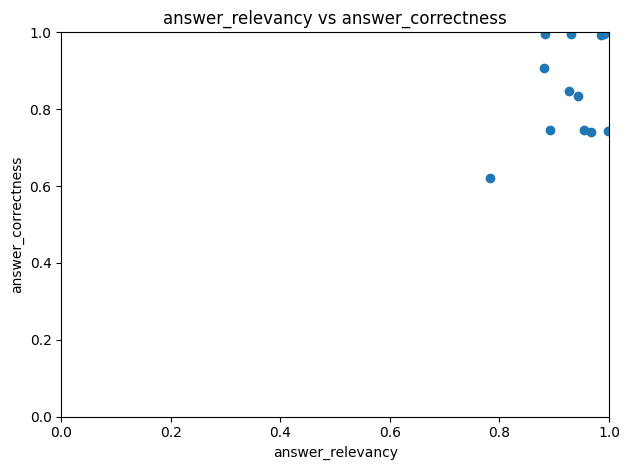

Saved: outputs/scatter_context_precision_vs_context_recall.png


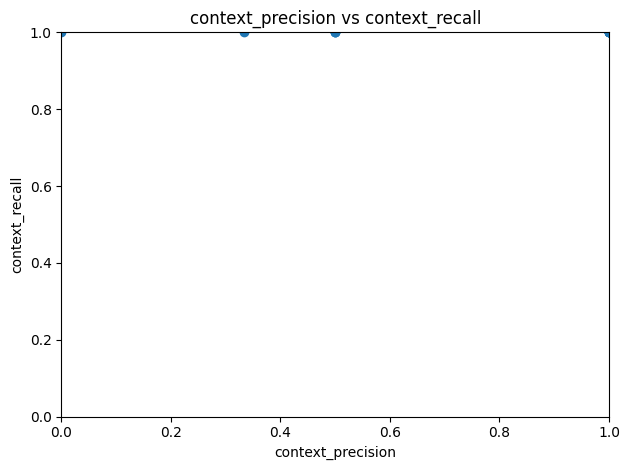

Saved: outputs/scatter_n_contexts_vs_answer_correctness.png


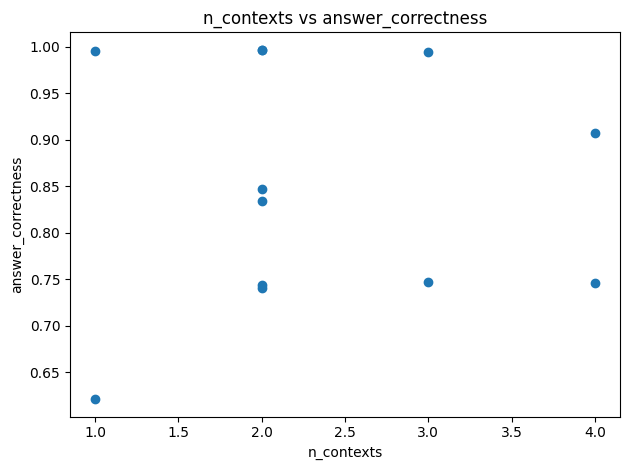

Saved: outputs/scatter_avg_context_len_vs_answer_correctness.png


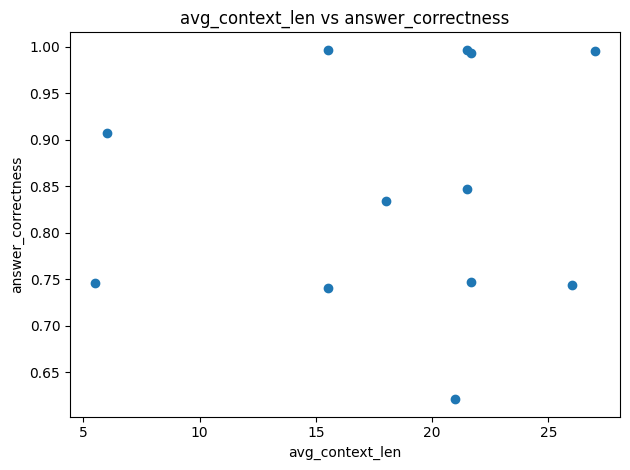

Saved: outputs/scatter_context_coverage_jaccard_vs_answer_correctness.png


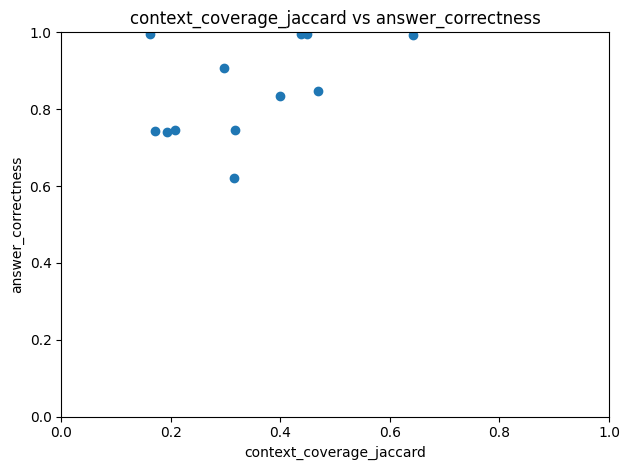

Saved: outputs/scatter_answer_coverage_jaccard_vs_answer_correctness.png


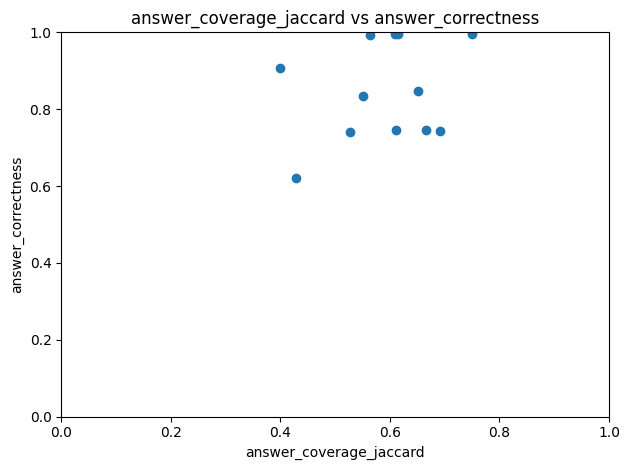

Saved: outputs/scatter_doc_recall_vs_answer_correctness.png


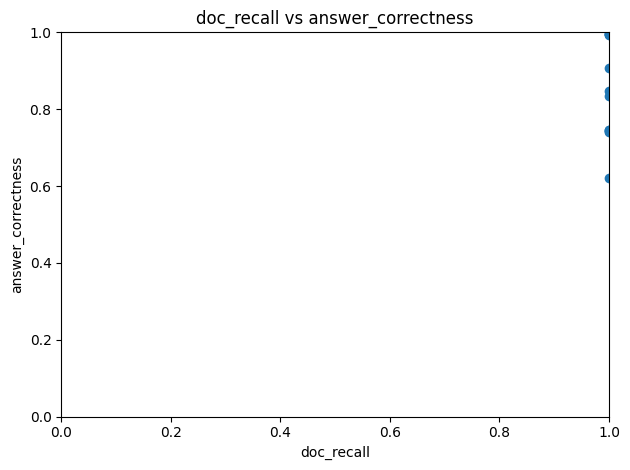

In [13]:

import matplotlib.pyplot as plt, os

BOUNDED01_COLS = set([
    "faithfulness","answer_correctness","context_precision","context_recall",
    "response_relevancy","answer_relevancy","doc_precision","doc_recall","doc_f1",
    "context_coverage_jaccard","answer_coverage_jaccard"
])

def scatter_xy(x, y):
    if x in df_all.columns and y in df_all.columns:
        plt.figure()
        plt.scatter(df_all[x], df_all[y])
        plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs {y}")
        if x in BOUNDED01_COLS and y in BOUNDED01_COLS:
            plt.xlim(0,1); plt.ylim(0,1)
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, f"scatter_{x}_vs_{y}.png")
        plt.savefig(outp); print("Saved:", outp)
        plt.show()

scatter_xy("faithfulness", "answer_correctness")
rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)
if rel_col: scatter_xy(rel_col, "answer_correctness")
scatter_xy("context_precision", "context_recall")
scatter_xy("n_contexts", "answer_correctness")
scatter_xy("avg_context_len", "answer_correctness")
scatter_xy("context_coverage_jaccard", "answer_correctness")
scatter_xy("answer_coverage_jaccard", "answer_correctness")
scatter_xy("doc_recall", "answer_correctness")


## 13) Corrélations — Matrice (Pearson, NaN masqués, échelle −1..1)

⚠️ Colonnes potentiellement non corrélables:
 - context_recall: constante (corrélation indéfinie)
 - doc_precision: constante (corrélation indéfinie)
 - doc_recall: constante (corrélation indéfinie)
 - doc_f1: constante (corrélation indéfinie)
Saved: outputs/corr_matrix.png


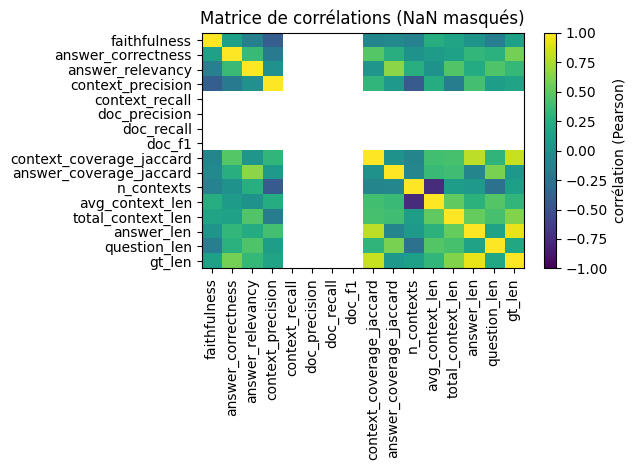

In [14]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

target_cols = [
    "faithfulness","answer_correctness",
    "response_relevancy" if "response_relevancy" in df_all.columns else "answer_relevancy",
    "context_precision","context_recall",
    "doc_precision","doc_recall","doc_f1",
    "context_coverage_jaccard","answer_coverage_jaccard",
    "n_contexts","avg_context_len","total_context_len",
    "answer_len","question_len","gt_len",
]

present_cols = [c for c in target_cols if c in df_all.columns]
df_num = df_all[present_cols].apply(pd.to_numeric, errors="coerce")

# Rapport colonnes non corrélables
report = []
for c in present_cols:
    s = df_num[c].dropna()
    if len(s) == 0:
        report.append(f"{c}: aucune valeur numérique (NaN)")
    elif s.nunique() <= 1:
        report.append(f"{c}: constante (corrélation indéfinie)")
if report:
    print("⚠️ Colonnes potentiellement non corrélables:")
    for r in report: print(" -", r)

corr = df_num.corr().reindex(index=present_cols, columns=present_cols)
masked = np.ma.masked_invalid(corr.values)

plt.figure()
im = plt.imshow(masked, aspect='auto', vmin=-1, vmax=1)  # échelle fixe
plt.xticks(range(len(present_cols)), present_cols, rotation=90)
plt.yticks(range(len(present_cols)), present_cols)
plt.colorbar(im, label="corrélation (Pearson)")
plt.title("Matrice de corrélations (NaN masqués)")
plt.tight_layout()
outp = os.path.join(OUTPUT_DIR, "corr_matrix.png")
plt.savefig(outp); print("Saved:", outp)
plt.show()


## 14) Effet du nombre de contextes — agrégations par *bins*

/tmp/ipykernel_12268/1502870579.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_all.groupby(b)[cols].mean(numeric_only=True).reset_index()


,n_contexts,faithfulness,answer_correctness,context_precision,context_recall,doc_recall,answer_relevancy
0,"(0, 1]",1.000000,0.808473,1.000000,1.0,1.0,0.832544
1,"(1, 2]",0.777778,0.859984,0.750000,1.0,1.0,0.959529
2,"(2, 3]",1.000000,0.870456,0.666667,1.0,1.0,0.939225
3,"(3, 4]",0.750000,0.826675,0.500000,1.0,1.0,0.917641
4,"(4, 6]",NaN,NaN,NaN,NaN,NaN,NaN
5,"(6, 10]",NaN,NaN,NaN,NaN,NaN,NaN
6,"(10, 999]",NaN,NaN,NaN,NaN,NaN,NaN


Saved: outputs/bar_faithfulness_by_ncontexts_bins.png


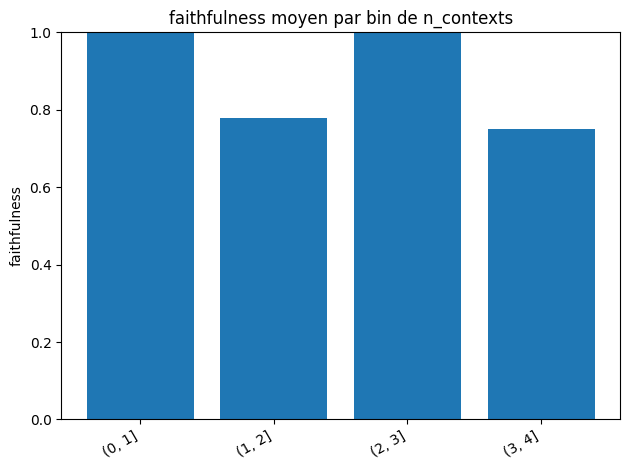

Saved: outputs/bar_answer_correctness_by_ncontexts_bins.png


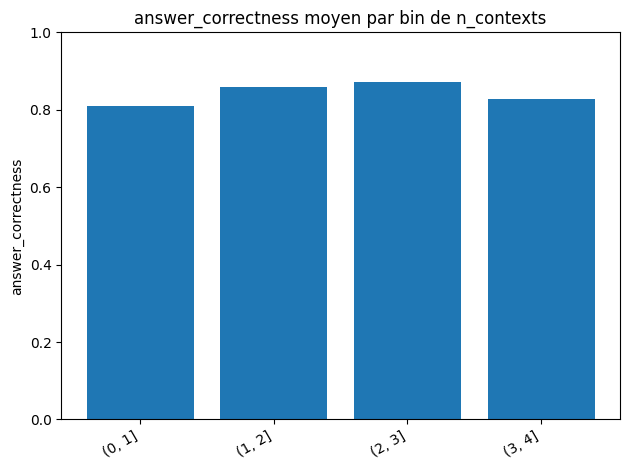

Saved: outputs/bar_context_precision_by_ncontexts_bins.png


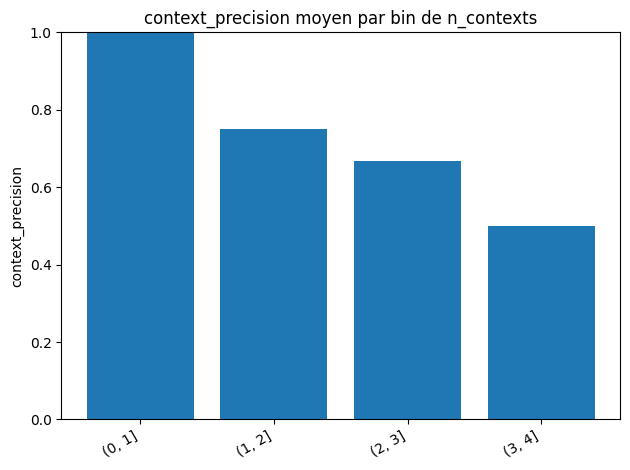

Saved: outputs/bar_context_recall_by_ncontexts_bins.png


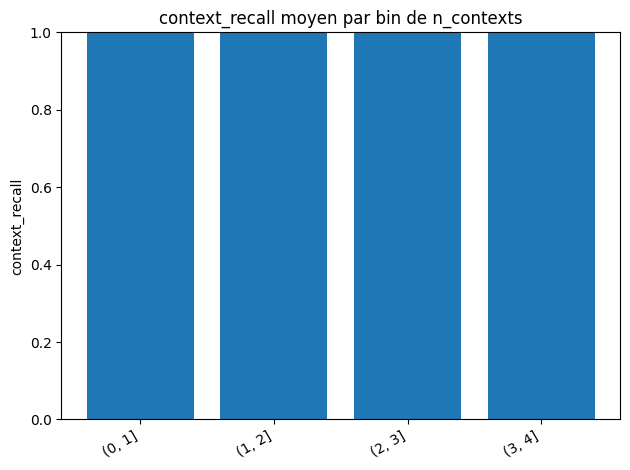

Saved: outputs/bar_doc_recall_by_ncontexts_bins.png


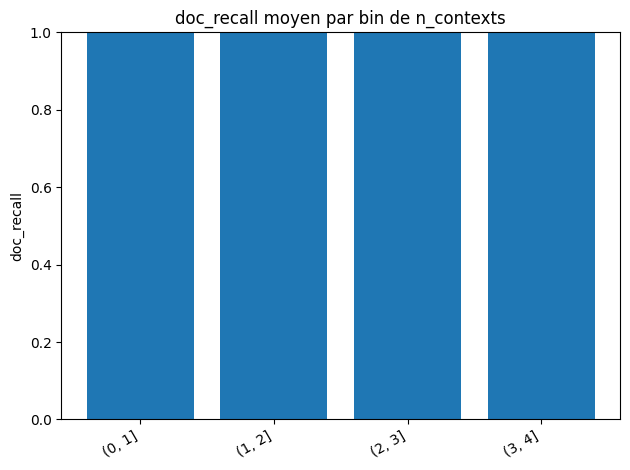

Saved: outputs/bar_answer_relevancy_by_ncontexts_bins.png


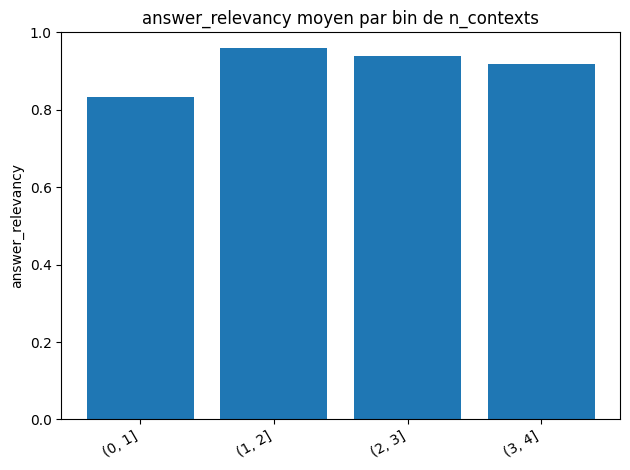

In [15]:

import pandas as pd, matplotlib.pyplot as plt, os

rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)

def agg_by_bins(col, bins=(0,1,2,3,4,6,10,999)):
    if col not in df_all.columns: return pd.DataFrame()
    b = pd.cut(df_all[col], bins=bins, right=True)
    cols = ["faithfulness","answer_correctness","context_precision","context_recall","doc_recall"]
    if rel_col and rel_col in df_all.columns: cols.append(rel_col)
    agg = df_all.groupby(b)[cols].mean(numeric_only=True).reset_index()
    return agg

agg_ctx = agg_by_bins("n_contexts")
display(agg_ctx)

for c in [c for c in agg_ctx.columns if c != "n_contexts"]:
    plt.figure()
    x = agg_ctx.iloc[:,0].astype(str); y = agg_ctx[c]
    plt.bar(x, y)
    if c in {"faithfulness","answer_correctness","context_precision","context_recall","doc_recall","response_relevancy","answer_relevancy"}:
        plt.ylim(0,1)
    plt.xticks(rotation=30, ha="right"); plt.ylabel(c); plt.title(f"{c} moyen par bin de n_contexts")
    plt.tight_layout()
    outp = os.path.join(OUTPUT_DIR, f"bar_{c}_by_ncontexts_bins.png"); plt.savefig(outp); print("Saved:", outp)
    plt.show()


## 15) Analyse par document/source (`sharepoint_document`)

,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall,doc_recall,doc_precision,doc_f1
sharepoint_document,,,,,,,,
Note de cadrage - Projet Neo.txt,1.000000,0.895438,0.937974,0.666667,1.0,1.0,1.0,1.0
Compte-Rendu de Reunion.txt,0.666667,0.854832,0.957047,0.875000,1.0,1.0,1.0,1.0
Repertoire equipe - Projet Neo.txt,0.833333,0.758197,0.872645,0.666667,1.0,1.0,1.0,1.0


Saved: outputs/bar_top_docs_answer_correctness.png


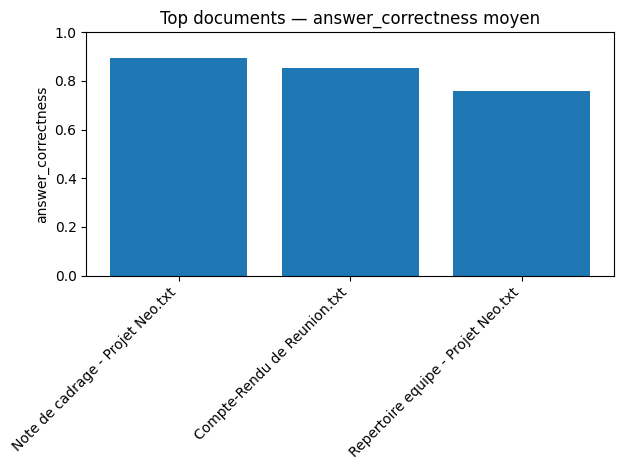

In [16]:

import pandas as pd, matplotlib.pyplot as plt, os

src_col = "sharepoint_document" if "sharepoint_document" in raw_df.columns else None
rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)

if src_col:
    metric_cols = ["faithfulness","answer_correctness","context_precision","context_recall","doc_recall","doc_precision","doc_f1"]
    if rel_col and rel_col in df_all.columns: metric_cols.insert(2, rel_col)
    per_src = pd.concat([raw_df[[src_col]], df_all[metric_cols]], axis=1)
    agg_src = per_src.groupby(src_col).mean(numeric_only=True).sort_values("answer_correctness", ascending=False)
    display(agg_src.head(10))

    topk = agg_src.head(10)
    if len(topk) > 0:
        plt.figure()
        plt.bar(topk.index.astype(str), topk["answer_correctness"])
        plt.ylim(0,1)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("answer_correctness")
        plt.title("Top documents — answer_correctness moyen")
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, "bar_top_docs_answer_correctness.png")
        plt.savefig(outp); print("Saved:", outp)
        plt.show()
else:
    print("Aucune colonne 'sharepoint_document' détectée.")


## 16) Recommandations automatiques (guidées par les métriques)

In [17]:

import os

reco = []

def add(msg):
    print("•", msg); reco.append("• " + msg)

mean = df_all.mean(numeric_only=True).to_dict()
m = lambda k: mean.get(k, None)

if (m("faithfulness") or 0) < 0.6:
    add("Fidélité basse : citations verbatim, température 0, format de sortie contraint, penaliser contenu hors‑contexte.")

if (m("answer_correctness") or 0) < 0.6 and (m("context_recall") or 0) >= 0.6:
    add("Réponses incorrectes malgré rappel correct : prompts d'extraction stricte + self‑check (ask‑to‑verify).")

if (m("context_recall") or 0) < 0.6:
    add("Rappel faible : +top‑k, recherche **hybride** (BM25+vecteur), meilleur **chunking** et **préprocessing** (OCR/headers/footers).")

if (m("context_precision") or 0) < 0.6:
    add("Précision faible : **reranker** (cross‑encoder/LLM), ‑top‑k avant génération, filtres métadonnées (doc_id, section).")

if "n_contexts" in df_all and "answer_correctness" in df_all and df_all["n_contexts"].corr(df_all["answer_correctness"]) < -0.15:
    add("Trop de contextes → réduire top‑k et/ou reranker plus agressivement.")

if (m("doc_recall") or 0) < 0.6:
    add("Faible rappel documentaire : uniformiser les **doc_id**, améliorer l’**extraction PDF** (tables, colonnes), citations automatiques.")

if (m("context_coverage_jaccard") or 0) < 0.4:
    add("Faible recouvrement GT↔Contexts : embeddings FR/domaine, découpe par **titres/sections**, enrichir index (titres/TOC).")

with open(os.path.join(OUTPUT_DIR, "auto_recommendations.txt"), "w", encoding="utf-8") as f:
    f.write("Recommandations automatiques\n\n"); [f.write(r+"\n") for r in reco]
print("Recommandations ->", os.path.join(OUTPUT_DIR, "auto_recommendations.txt"))


• Faible recouvrement GT↔Contexts : embeddings FR/domaine, découpe par **titres/sections**, enrichir index (titres/TOC).
Recommandations -> outputs/auto_recommendations.txt


## 17) Plan d’expériences (A/B & grille)

In [18]:

import json, os

param_grid = {
    "preprocess": [
        {"ocr": False, "clean_headers": True, "normalize_ws": True},
        {"ocr": True,  "clean_headers": True, "normalize_ws": True},
    ],
    "embedding": [
        {"provider":"openai","model":"text-embedding-3-large"},
        {"provider":"openai","model":"text-embedding-3-small"},
        {"provider":"nomic","model":"nomic-embed-text"},
    ],
    "chunking": [
        {"method":"fixed","size":512,"overlap":64},
        {"method":"fixed","size":800,"overlap":100},
        {"method":"semantic","size":"auto","overlap":64},
    ],
    "retrieval": [
        {"type":"vector","top_k":8},
        {"type":"hybrid","bm25_weight":0.4,"top_k":8},
        {"type":"hybrid","bm25_weight":0.6,"top_k":12},
    ],
    "rerank": [
        {"enabled": False},
        {"enabled": True, "model":"cross-encoder/ms-marco-MiniLM-L-6-v2", "top_k":5},
    ],
}
grid_out = os.path.join(OUTPUT_DIR, "experiment_plan.json")
with open(grid_out, "w", encoding="utf-8") as f:
    json.dump(param_grid, f, ensure_ascii=False, indent=2)
print("Plan d'expériences ->", grid_out)


Plan d'expériences -> outputs/experiment_plan.json



## 18) Dashboard comparatif **multi‑runs** (baseline vs variantes)

**Préparez** plusieurs runs (chacun avec `ragas_results_enriched.csv`) dans des sous‑dossiers de `outputs/` :  
`outputs/baseline/…`, `outputs/hybrid/…`, `outputs/rerank/…`

La cellule ci‑dessous autodétecte, calcule les moyennes, **barres** (0–1), **boxplots** (0–1) et **Δ vs baseline**.


Runs détectés:
 - outputs/ragas_results_enriched.csv


,faithfulness,answer_correctness,relevancy,context_precision,context_recall,doc_precision,doc_recall,doc_f1
run,,,,,,,,
outputs,0.847222,0.847592,0.928,0.736111,1.0,1.0,1.0,1.0


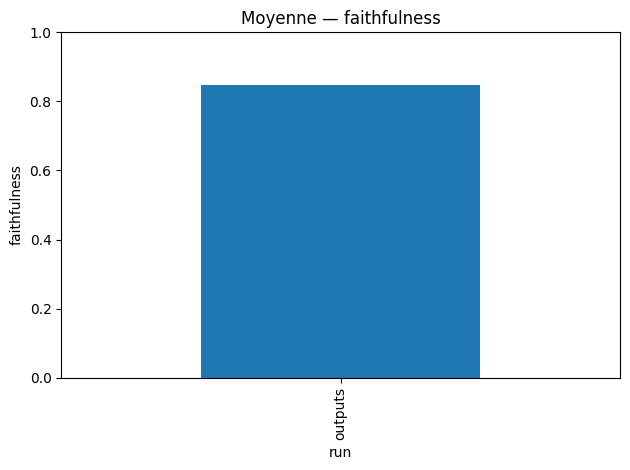

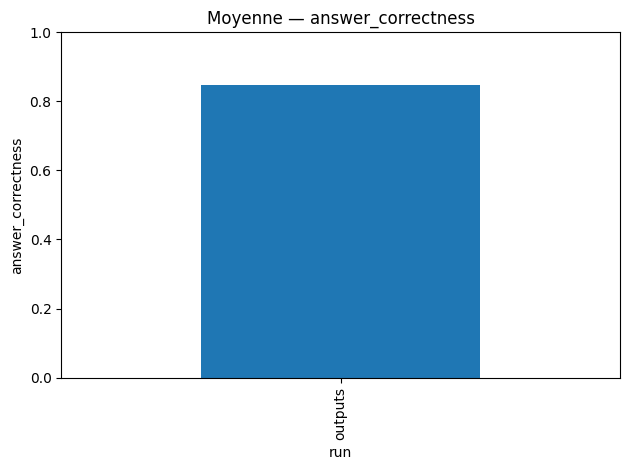

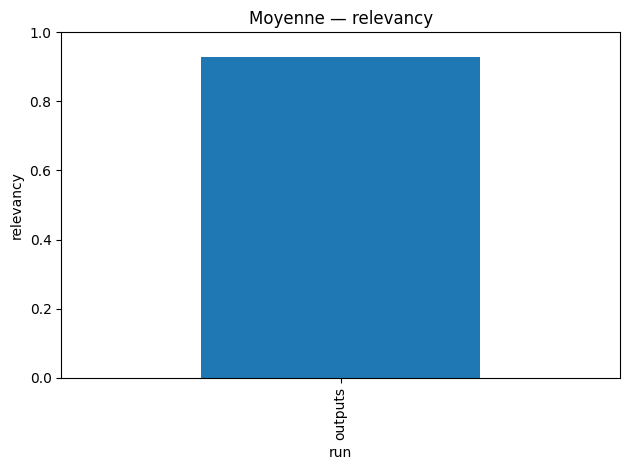

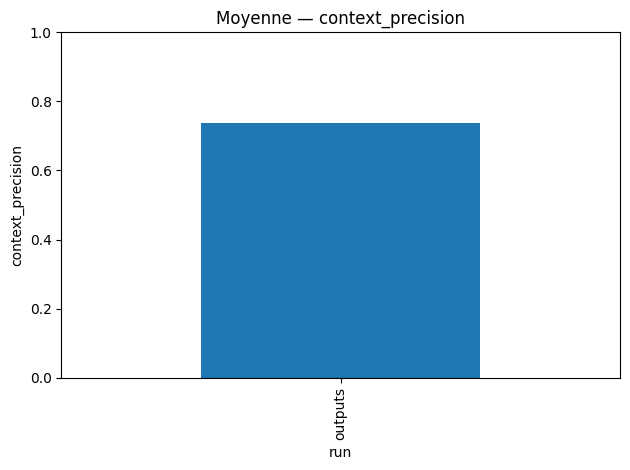

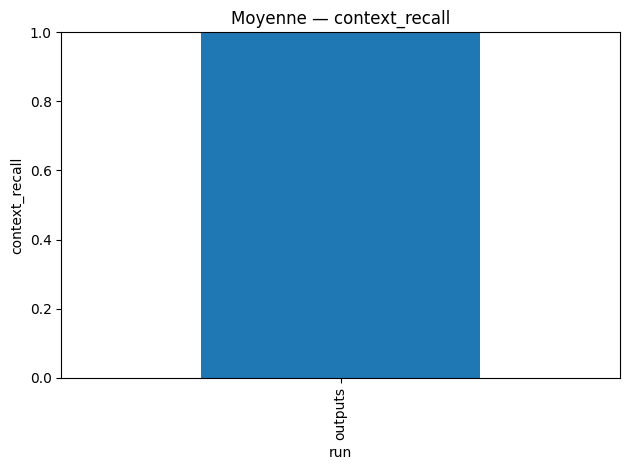

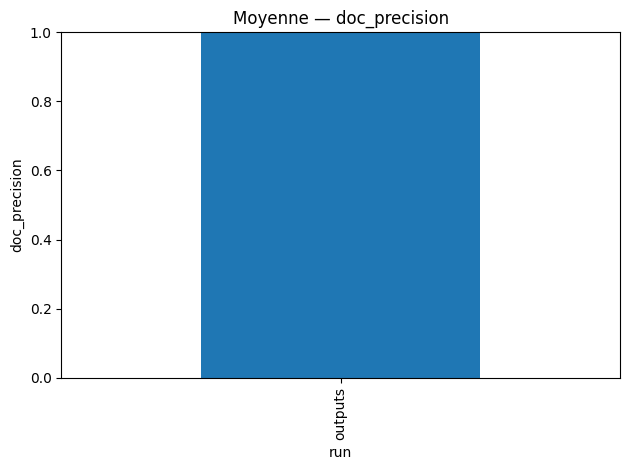

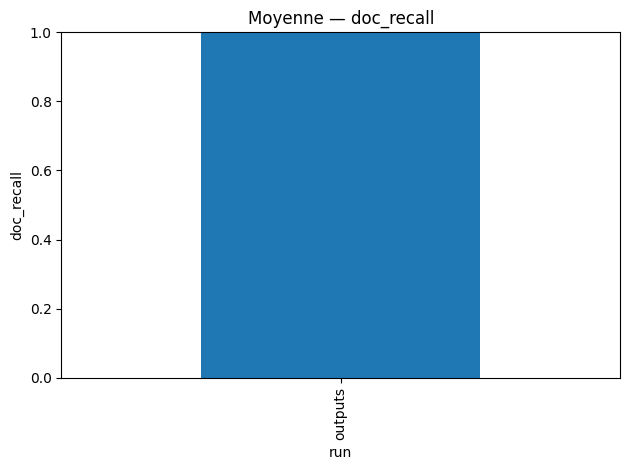

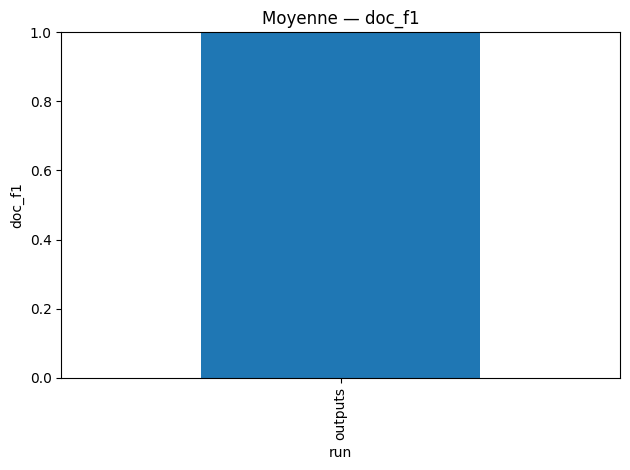

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


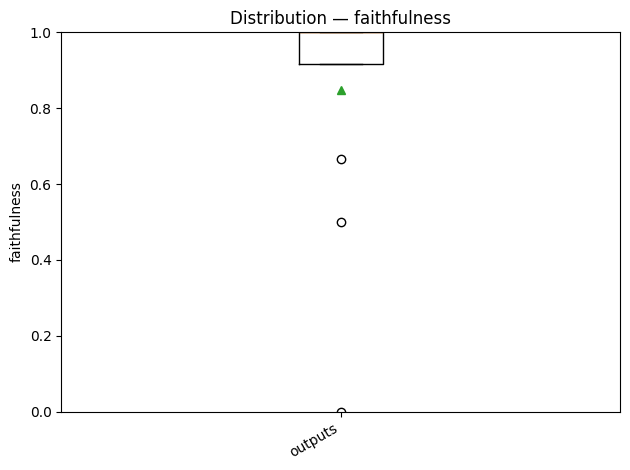

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


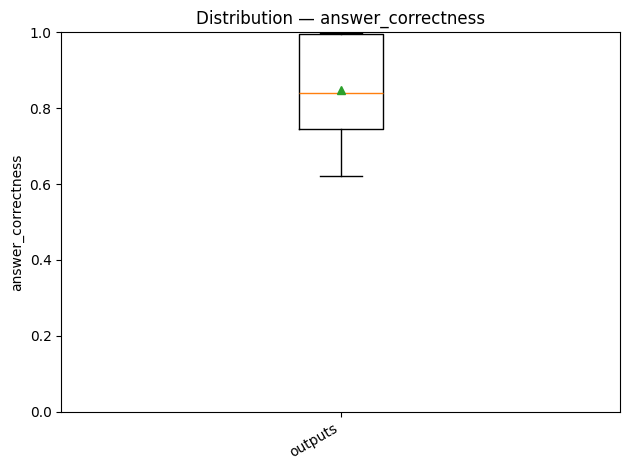

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


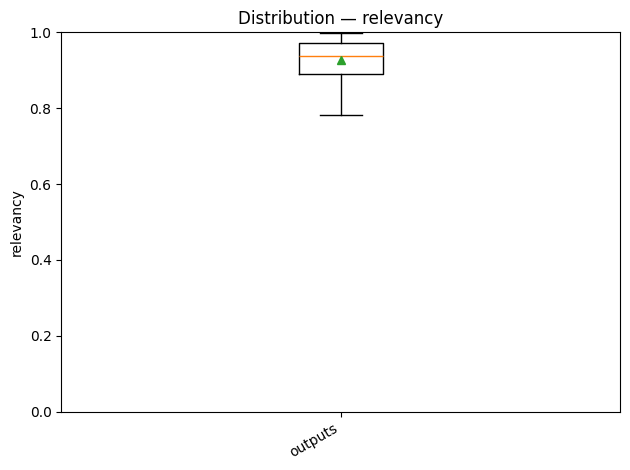

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


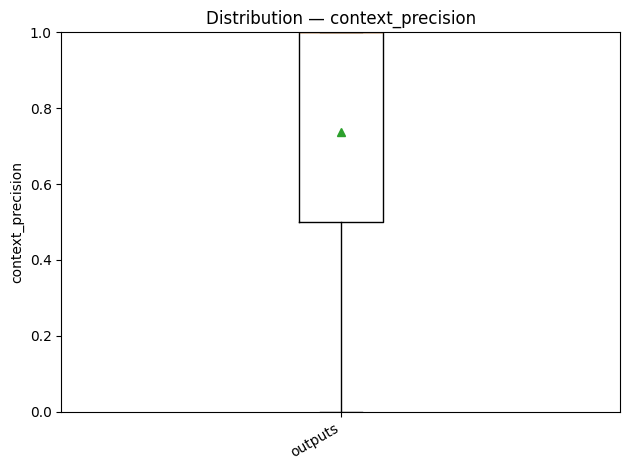

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


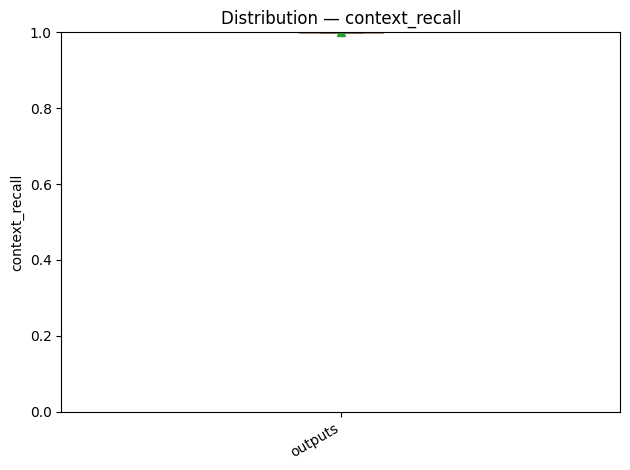

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


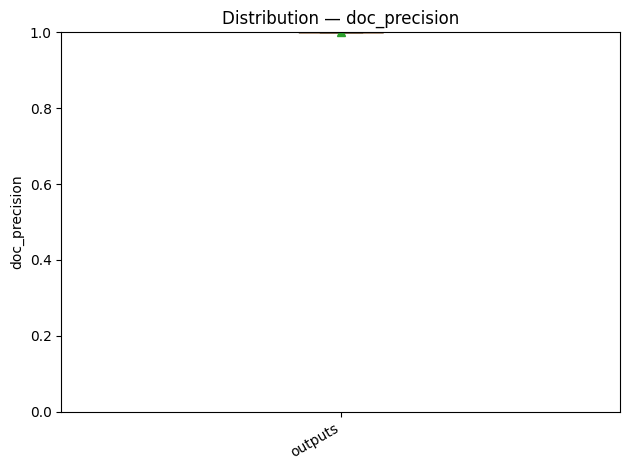

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


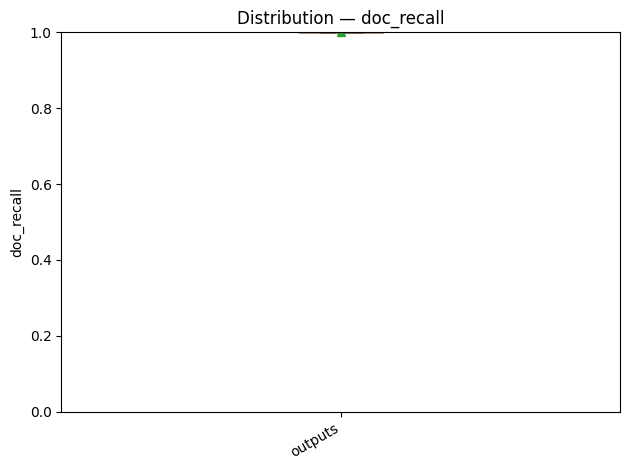

/tmp/ipykernel_12268/243094377.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


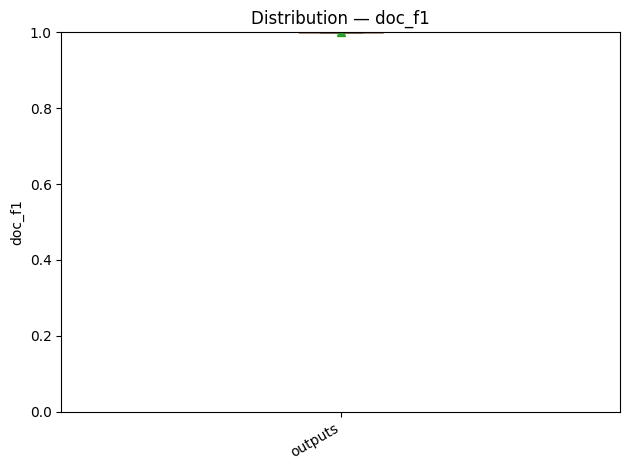

Δ vs baseline : besoin d'au moins 2 runs.


In [19]:

import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

auto_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, "**", "ragas_results_enriched.csv"), recursive=True))
RUN_PATHS = []  # Ajoutez des chemins explicites si besoin
all_paths = RUN_PATHS if RUN_PATHS else auto_paths

if not all_paths:
    print("⚠️ Aucun run trouvé. Placez des fichiers 'ragas_results_enriched.csv' dans des sous-dossiers de 'outputs/'.")
else:
    print("Runs détectés:")
    for p in all_paths: print(" -", p)

def unify_cols(df):
    if "response_relevancy" in df.columns: df["relevancy"] = df["response_relevancy"]
    elif "answer_relevancy" in df.columns: df["relevancy"] = df["answer_relevancy"]
    for c in ["faithfulness","answer_correctness","relevancy","context_precision","context_recall","doc_precision","doc_recall","doc_f1","context_coverage_jaccard","answer_coverage_jaccard"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").clip(0,1)
    return df

runs = []
for p in all_paths:
    try:
        df_run = pd.read_csv(p)
        df_run = unify_cols(df_run)
        run_id = os.path.basename(os.path.dirname(p)) or "run"
        runs.append((run_id, df_run))
    except Exception as e:
        print("Skip", p, "->", e)

metrics = ["faithfulness","answer_correctness","relevancy","context_precision","context_recall","doc_precision","doc_recall","doc_f1"]

summary_rows = []
for run_id, df_run in runs:
    row = {"run": run_id}
    for m in metrics:
        if m in df_run.columns:
            row[m] = float(np.nanmean(df_run[m]))
    summary_rows.append(row)

import pandas as pd
df_summary = pd.DataFrame(summary_rows).set_index("run").sort_index()
display(df_summary)
df_summary.to_csv(os.path.join(OUTPUT_DIR, "multirun_summary.csv"), encoding="utf-8")

# Barres (0–1 fixes)
for m in metrics:
    if m in df_summary.columns:
        plt.figure()
        df_summary[m].plot(kind="bar", title=f"Moyenne — {m}")
        plt.ylim(0,1)
        plt.ylabel(m)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"multirun_bar_{m}.png"))
        plt.show()

# Boxplots (0–1 fixes)
for m in metrics:
    data, labels = [], []
    for run_id, df_run in runs:
        if m in df_run.columns:
            data.append(df_run[m].dropna().clip(0,1).values)
            labels.append(run_id)
    if data:
        plt.figure()
        plt.boxplot(data, labels=labels, showmeans=True)
        plt.ylim(0,1)
        plt.title(f"Distribution — {m}")
        plt.ylabel(m)
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"multirun_box_{m}.png"))
        plt.show()

# Δ vs baseline (premier run)
if len(runs) >= 2:
    base_id, base_df = runs[0]
    base_means = {m: float(np.nanmean(base_df[m])) for m in metrics if m in base_df.columns}
    for m in base_means:
        xs, ys = [], []
        for run_id, df_run in runs[1:]:
            if m in df_run.columns:
                xs.append(run_id)
                ys.append(float(np.nanmean(df_run[m])) - base_means[m])
        if xs:
            plt.figure()
            plt.bar(xs, ys)
            plt.axhline(0, linestyle="--")
            plt.ylabel(f"Δ {m} (vs {base_id})")
            plt.title(f"Delta moyenne — {m}")
            plt.xticks(rotation=30, ha="right")
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, f"multirun_delta_{m}_vs_{base_id}.png"))
            plt.show()
else:
    print("Δ vs baseline : besoin d'au moins 2 runs.")
